In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.kalman_filter import KalmanFilter
from statsmodels.tsa.statespace.mlemodel import MLEModel

# Optional: Set the aesthetics for seaborn
sns.set(style='whitegrid')

In [2]:
# Set the correct path to your CSV file
path_to_fed_data = "/Users/biancafernandes/Documents/FTD_Semestre_1/Asset pricing/M-FEDFUNDS.csv"

# Load the data from the CSV file
df_fed = pd.read_csv(path_to_fed_data)
df_fed['DATE'] = pd.to_datetime(df_fed['DATE'], errors='coerce')
df_fed.head()

,DATE,FEDFUNDS
0,1996-01-01,5.56
1,1996-02-01,5.22
2,1996-03-01,5.31
3,1996-04-01,5.22
4,1996-05-01,5.24


In [3]:
# Set the correct path to your CSV file
path_to_um_data = "/Users/biancafernandes/Documents/FTD_Semestre_1/Asset pricing/M-UNRATE.csv"

# Load the data from the CSV file
df_um = pd.read_csv(path_to_um_data)
df_um['DATE'] = pd.to_datetime(df_um['DATE'], errors='coerce')
df_um

,DATE,UNRATE
0,1996-01-01,5.6
1,1996-02-01,5.5
2,1996-03-01,5.5
3,1996-04-01,5.6
4,1996-05-01,5.6
...,...,...
340,2024-05-01,4.0
341,2024-06-01,4.1
342,2024-07-01,4.3
343,2024-08-01,4.2


In [4]:
# Set the correct path to your CSV file
path_to_gdp_data = "/Users/biancafernandes/Documents/FTD_Semestre_1/Asset pricing/GDP_growth.csv"

# Load the data from the CSV file
df_gdp = pd.read_csv(path_to_gdp_data)

df_gdp = df_gdp.rename(columns={'A191RL1Q225SBEA': 'GDP'})
df_gdp['DATE'] = pd.to_datetime(df_gdp['DATE'], errors='coerce')
df_gdp

,DATE,GDP
0,1996-01-01,3.0
1,1996-04-01,6.8
2,1996-07-01,3.6
3,1996-10-01,4.2
4,1997-01-01,2.6
...,...,...
109,2023-04-01,2.4
110,2023-07-01,4.4
111,2023-10-01,3.2
112,2024-01-01,1.6


In [5]:
df_yc = df_fed.merge(df_um, on = "DATE").merge(df_gdp, on = "DATE")
df_yc.set_index('DATE', inplace=True)
df_yc

,FEDFUNDS,UNRATE,GDP
DATE,,,
1996-01-01,5.56,5.6,3.0
1996-04-01,5.22,5.6,6.8
1996-07-01,5.40,5.5,3.6
1996-10-01,5.24,5.2,4.2
1997-01-01,5.25,5.3,2.6
...,...,...,...
2023-04-01,4.83,3.4,2.4
2023-07-01,5.12,3.5,4.4
2023-10-01,5.33,3.8,3.2


In [6]:
from pandas_datareader.fred import FredReader

fred_indicators = ['CPIAUCSL', # Inflation
                  'GS1', 
                   'GS2', 
                   'GS5', 
                   'GS10', 
                   'GS20', 
                   'GS30', 
                  ] 

df = FredReader(symbols=fred_indicators, start='1900', end=None).read()

rename_dict = {'CPIAUCSL':'Inflation',
              'GS1':'1Y',
               'GS2':'2Y',
               'GS5':'5Y',
               'GS10':'10Y',
               'GS20':'20Y',
               'GS30':'30Y',
              }
df = df.rename(columns=rename_dict)


df = df.dropna()
df

,Inflation,1Y,2Y,5Y,10Y,20Y,30Y
DATE,,,,,,,
1977-02-01,59.300,5.47,6.09,6.83,7.39,7.64,7.75
1977-03-01,59.600,5.50,6.09,6.93,7.46,7.73,7.80
1977-04-01,60.000,5.44,5.96,6.79,7.37,7.67,7.73
1977-05-01,60.200,5.84,6.25,6.94,7.46,7.74,7.80
1977-06-01,60.500,5.80,6.13,6.76,7.28,7.64,7.64
...,...,...,...,...,...,...,...
2024-05-01,313.225,5.16,4.86,4.50,4.48,4.71,4.62
2024-06-01,313.049,5.11,4.74,4.32,4.31,4.54,4.44
2024-07-01,313.534,4.90,4.50,4.16,4.25,4.56,4.46


In [7]:
df_yc = df_yc.merge(df, on = "DATE")
df_yc

,FEDFUNDS,UNRATE,GDP,Inflation,1Y,2Y,5Y,10Y,20Y,30Y
DATE,,,,,,,,,,
1996-01-01,5.56,5.6,3.0,154.700,5.09,5.11,5.36,5.65,6.11,6.05
1996-04-01,5.22,5.6,6.8,156.100,5.54,5.96,6.30,6.51,6.98,6.79
1996-07-01,5.40,5.5,3.6,157.000,5.85,6.27,6.64,6.87,7.14,7.03
1996-10-01,5.24,5.2,4.2,158.200,5.55,5.91,6.27,6.53,6.90,6.81
1997-01-01,5.25,5.3,2.6,159.400,5.61,6.01,6.33,6.58,6.91,6.83
...,...,...,...,...,...,...,...,...,...,...
2023-04-01,4.83,3.4,2.4,303.032,4.68,4.02,3.54,3.46,3.80,3.68
2023-07-01,5.12,3.5,4.4,304.628,5.37,4.83,4.14,3.90,4.15,3.96
2023-10-01,5.33,3.8,3.2,307.531,5.42,5.07,4.77,4.80,5.13,4.95


# Ploting the Yield Curves

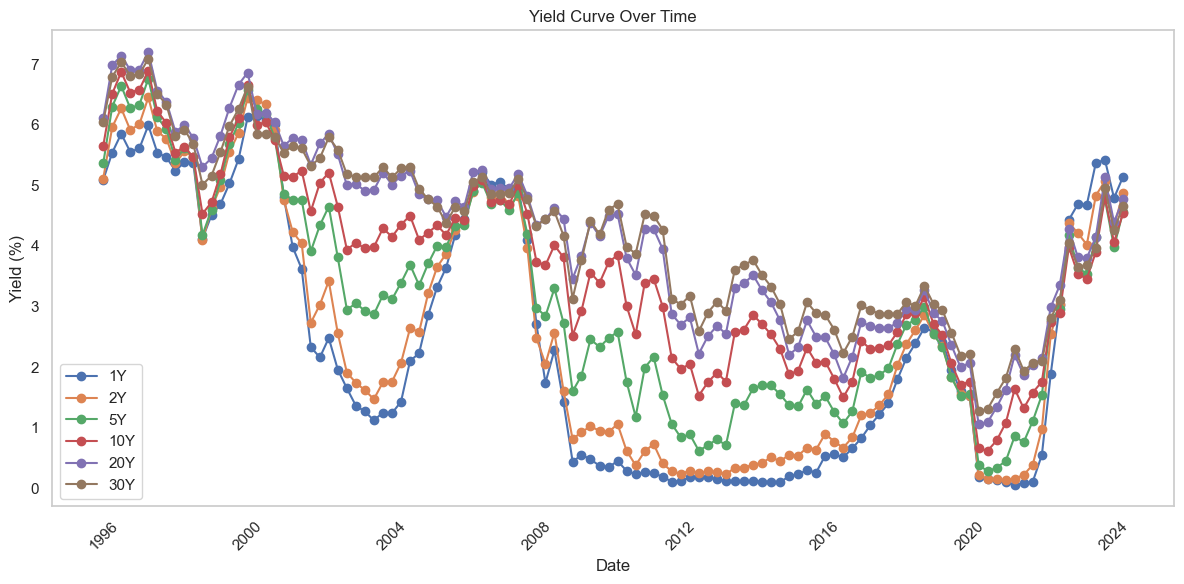

In [8]:
# Plot the Yield Curve
plt.figure(figsize=(12, 6))
plt.plot(df_yc.index, df_yc['1Y'], label='1Y', marker='o')
plt.plot(df_yc.index, df_yc['2Y'], label='2Y', marker='o')
plt.plot(df_yc.index, df_yc['5Y'], label='5Y', marker='o')
plt.plot(df_yc.index, df_yc['10Y'], label='10Y', marker='o')
plt.plot(df_yc.index, df_yc['20Y'], label='20Y', marker='o')
plt.plot(df_yc.index, df_yc['30Y'], label='30Y', marker='o')

plt.title('Yield Curve Over Time')
plt.xlabel('Date')
plt.ylabel('Yield (%)')
plt.legend()
plt.grid()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Ploting Macroeconomic Factors

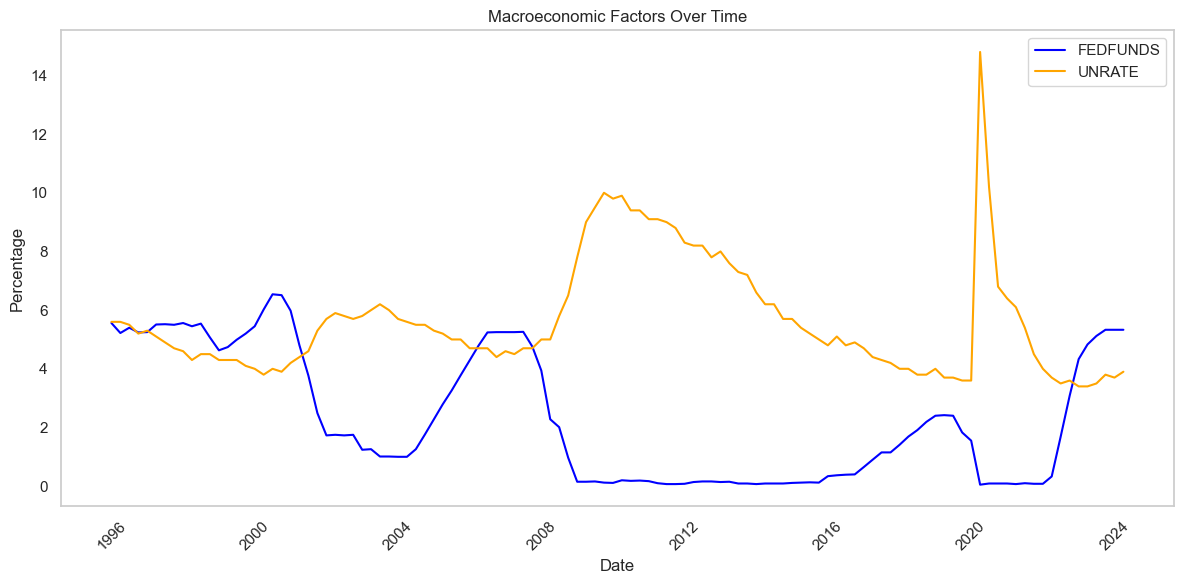

In [9]:
# Plot Macroeconomic Factors
plt.figure(figsize=(12, 6))
plt.plot(df_yc.index, df_yc['FEDFUNDS'], label='FEDFUNDS', color='blue')
plt.plot(df_yc.index, df_yc['UNRATE'], label='UNRATE', color='orange')

plt.title('Macroeconomic Factors Over Time')
plt.xlabel('Date')
plt.ylabel('Percentage')
plt.legend()
plt.grid()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Summary Statistics

In [10]:
# Additional summary statistics
additional_stats = df_yc.agg(['mean', 'std', 'min', 'max', 'skew', 'kurtosis'])

# Display the additional statistics
print(additional_stats)

          FEDFUNDS     UNRATE        GDP   Inflation        1Y        2Y  \
mean      2.337719   5.628947   2.602632  218.391447  2.436404  2.636491   
std       2.206774   1.954243   4.877716   40.947545  2.112080  2.042028   
min       0.050000   3.400000 -28.100000  154.700000  0.060000  0.130000   
max       6.540000  14.800000  35.200000  313.207000  6.150000  6.450000   
skew      0.451443   1.646974   0.285593    0.357460  0.385258  0.392491   
kurtosis -1.441612   3.568414  30.638593   -0.561155 -1.430125 -1.279252   

                5Y       10Y       20Y       30Y  
mean      3.138684  3.650789  4.155263  4.201754  
std       1.775748  1.556386  1.538498  1.402683  
min       0.280000  0.620000  1.060000  1.270000  
max       6.760000  6.890000  7.200000  7.090000  
skew      0.308561  0.165226  0.025240  0.019368  
kurtosis -1.018411 -0.849631 -0.965614 -0.850570  


# Stationarity Test

In [11]:
def ADF_test_summary(df, maxlag=None, autolag='BIC', missing='error'):
    if missing == 'error':
        if df.isna().any().any():
            raise ValueError("df has missing data; handle it or pass missing='drop' to automatically drop it.")

    if isinstance(df, pd.Series):
        df = df.to_frame()

    for series in df.columns:
        data = df[series].copy()
        if missing == 'drop':
            data.dropna(inplace=True)

        print(series.center(110))
        print(('=' * 110))
        line = 'Specification' + ' ' * 15 + 'Coeff' + ' ' * 10 + 'Statistic' + ' ' * 5 + 'P-value' + ' ' * 6 + 'Lags' + ' ' * 6 + '1%'
        line += ' ' * 10 + '5%' + ' ' * 8 + '10%'
        print(line)
        print(('-' * 110))
        spec_fixed = False
        for i, (name, reg) in enumerate(zip(['Constant and Trend', 'Constant Only', 'No Constant'], ['ct', 'c', 'n'])):
            stat, p, crit, regresult = sm.tsa.adfuller(data, regression=reg, regresults=True, maxlag=maxlag,
                                                       autolag=autolag)
            n_lag = regresult.usedlag
            gamma = regresult.resols.params[0]
            names = make_var_names(series, n_lag, reg)
            reg_coefs = pd.Series(regresult.resols.params, index=names)
            reg_tstat = pd.Series(regresult.resols.tvalues, index=names)
            reg_pvals = pd.Series(regresult.resols.pvalues, index=names)

            line = f'{name:<21}{gamma:13.3f}{stat:15.3f}{p:13.3f}{n_lag:11}{crit["1%"]:10.3f}{crit["5%"]:12.3f}{crit["10%"]:11.3f}'
            print(line)

            for coef in reg_coefs.index:
                if coef in name:
                    line = f"\t{coef:<13}{reg_coefs[coef]:13.3f}{reg_tstat[coef]:15.3f}{reg_pvals[coef]:13.3f}"
                    print(line)

def make_var_names(var, n_lags, reg):
    names = [f'L1.{var}']
    for lag in range(1, n_lags + 1):
        names.append(f'D{lag}L1.{var}')
    if reg != 'n':
        names.append('Constant')
    if 't' in reg:
        names.append('Trend')

    return names

In [12]:
ADF_test_summary(df_yc, missing='drop')

                                                   FEDFUNDS                                                   
Specification               Coeff          Statistic     P-value      Lags      1%          5%        10%
--------------------------------------------------------------------------------------------------------------
Constant and Trend          -0.042         -2.359        0.402          1    -4.042      -3.450     -3.150
	Constant             0.141          1.377        0.171
	Trend               -0.001         -0.634        0.528
Constant Only               -0.035         -2.441        0.130          1    -3.490      -2.888     -2.581
	Constant             0.083          1.823        0.071
No Constant                 -0.016         -1.609        0.102          1    -2.586      -1.944     -1.615
                                                    UNRATE                                                    
Specification               Coeff          Statistic     P-value      La

# Detrending

In [13]:
# Differencing to remove trend
df_yc_diff = pd.DataFrame()

df_yc_diff['FEDFUNDS'] = df_yc['FEDFUNDS'].diff()
df_yc_diff['Inflation'] = df_yc['Inflation'].diff()
df_yc_diff['UNRATE'] = df_yc['UNRATE'].diff()
df_yc_diff['GDP'] = df_yc['GDP']
df_yc_diff['1Y'] = df_yc['1Y'].diff()
df_yc_diff['2Y'] = df_yc['2Y'].diff()
df_yc_diff['5Y'] = df_yc['5Y'].diff()
df_yc_diff['10Y'] = df_yc['10Y'].diff()
df_yc_diff['20Y'] = df_yc['20Y'].diff()
df_yc_diff['30Y'] = df_yc['30Y'].diff()

# Drop the first row since differencing creates NaN
df_yc_diff.dropna(inplace=True)

In [14]:
ADF_test_summary(df_yc_diff, missing='drop')

                                                   FEDFUNDS                                                   
Specification               Coeff          Statistic     P-value      Lags      1%          5%        10%
--------------------------------------------------------------------------------------------------------------
Constant and Trend          -0.342         -4.745        0.001          0    -4.042      -3.450     -3.150
	Constant            -0.047         -0.713        0.477
	Trend                0.001          0.858        0.393
Constant Only               -0.329         -4.675        0.000          0    -3.490      -2.888     -2.581
	Constant             0.002          0.074        0.942
No Constant                 -0.329         -4.696        0.000          0    -2.586      -1.944     -1.615
                                                  Inflation                                                   
Specification               Coeff          Statistic     P-value      La

In [15]:
df_yc_diff.head()

,FEDFUNDS,Inflation,UNRATE,GDP,1Y,2Y,5Y,10Y,20Y,30Y
DATE,,,,,,,,,,
1996-04-01,-0.34,1.4,0.0,6.8,0.45,0.85,0.94,0.86,0.87,0.74
1996-07-01,0.18,0.9,-0.1,3.6,0.31,0.31,0.34,0.36,0.16,0.24
1996-10-01,-0.16,1.2,-0.3,4.2,-0.30,-0.36,-0.37,-0.34,-0.24,-0.22
1997-01-01,0.01,1.2,0.1,2.6,0.06,0.10,0.06,0.05,0.01,0.02
1997-04-01,0.26,0.5,-0.2,6.8,0.38,0.44,0.43,0.31,0.29,0.26


# Nelson-Siegel Model

In [16]:
import numpy as np

def nelson_siegel(t, beta0, beta1, beta2, tau):
    term1 = (1 - np.exp(-t / tau)) / (t / tau)
    term2 = term1 - np.exp(-t / tau)
    return beta0 + beta1 * term1 + beta2 * term2

In [17]:
import statsmodels.api as sm

# Example of preparing the data for regression
df_yc_diff['Maturity'] = df_yc_diff.index.astype(np.int64) // 10**9  # Convert to a numeric representation for regression

# Reshape the data for detrended yields (1Y, 2Y, etc.)
detrended_yields = df_yc_diff[['1Y', '2Y', '5Y', '10Y', '20Y', '30Y']].values.flatten()
maturity = np.tile(df_yc_diff['Maturity'], 6)  # Repeat maturity for each yield
fedfunds = np.tile(df_yc_diff['FEDFUNDS'], 6)
unrate = np.tile(df_yc_diff['UNRATE'], 6)
gdp = np.tile(df_yc_diff['GDP'], 6)
inflation = np.tile(df_yc_diff['Inflation'], 6)

# Create design matrix
X = np.column_stack((maturity, fedfunds, unrate, gdp, inflation))
X = sm.add_constant(X)  # Add constant term for the intercept

In [19]:
# Fit the model
model = sm.OLS(detrended_yields, X).fit()

# Display the model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     3.602
Date:                Fri, 01 Nov 2024   Prob (F-statistic):            0.00319
Time:                        17:38:38   Log-Likelihood:                -403.30
No. Observations:                 678   AIC:                             818.6
Df Residuals:                     672   BIC:                             845.7
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.3027      0.092     -3.306      0.0

# Nelson-Siegel Model for yield groups

In [19]:
# Define yield groups
short_term_yields = ['1Y', '2Y']
medium_term_yields = ['5Y', '10Y']
long_term_yields = ['20Y', '30Y']

# Function to run OLS regression for a given yield group
def run_regression(yield_group, group_name):
    for yield_col in yield_group:
        y = df_yc_diff[yield_col]  # Select the yield column
        X = df_yc_diff[['FEDFUNDS', 'UNRATE', 'GDP', 'Inflation']]  # Independent variables
        
        # Add a constant to the independent variables
        X = sm.add_constant(X)
        
        # Fit the OLS model
        model = sm.OLS(y, X).fit()
        
        # Print the summary of the regression results
        print(f'Regression Results for {yield_col} ({group_name}):\n')
        print(model.summary())
        print('\n' + '-'*80 + '\n')

# Run regressions for each yield group
run_regression(short_term_yields, 'Short-Term')
run_regression(medium_term_yields, 'Medium-Term')
run_regression(long_term_yields, 'Long-Term')

Regression Results for 1Y (Short-Term):

                            OLS Regression Results                            
Dep. Variable:                     1Y   R-squared:                       0.614
Model:                            OLS   Adj. R-squared:                  0.600
Method:                 Least Squares   F-statistic:                     43.00
Date:                Sat, 26 Oct 2024   Prob (F-statistic):           1.55e-21
Time:                        18:47:44   Log-Likelihood:                -20.538
No. Observations:                 113   AIC:                             51.08
Df Residuals:                     108   BIC:                             64.71
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      